In [2]:

# LIBRERÍAS Y CONFIGURACIÓN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

# CARGA DE DATOS
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# PREPROCESAMIENTO
df = df.copy()

# Eliminar ID irrelevante
df.drop('customerID', axis=1, inplace=True)

# Convertir TotalCharges a numérico
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Eliminar filas con valores nulos
df.dropna(inplace=True)

# Unificar categorías similares
df.replace(['No internet service', 'No phone service'], 'No', inplace=True)

# Eliminar la variable objetivo 'Churn' (es análisis NO supervisado)
df.drop('Churn', axis=1, inplace=True)

# Codificar variables categóricas
df_encoded = pd.get_dummies(df, drop_first=True)

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)


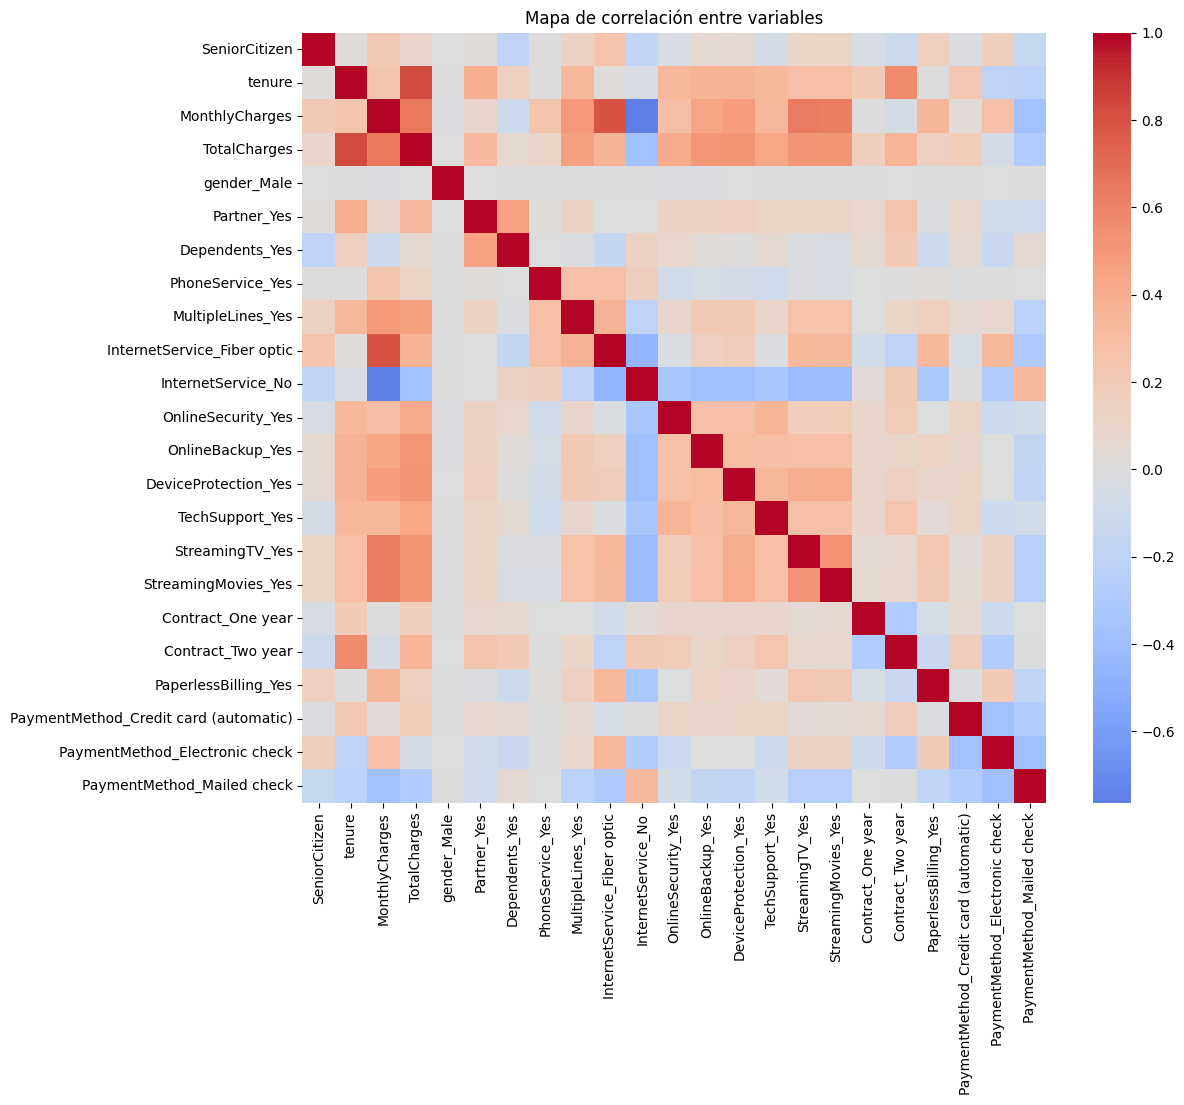

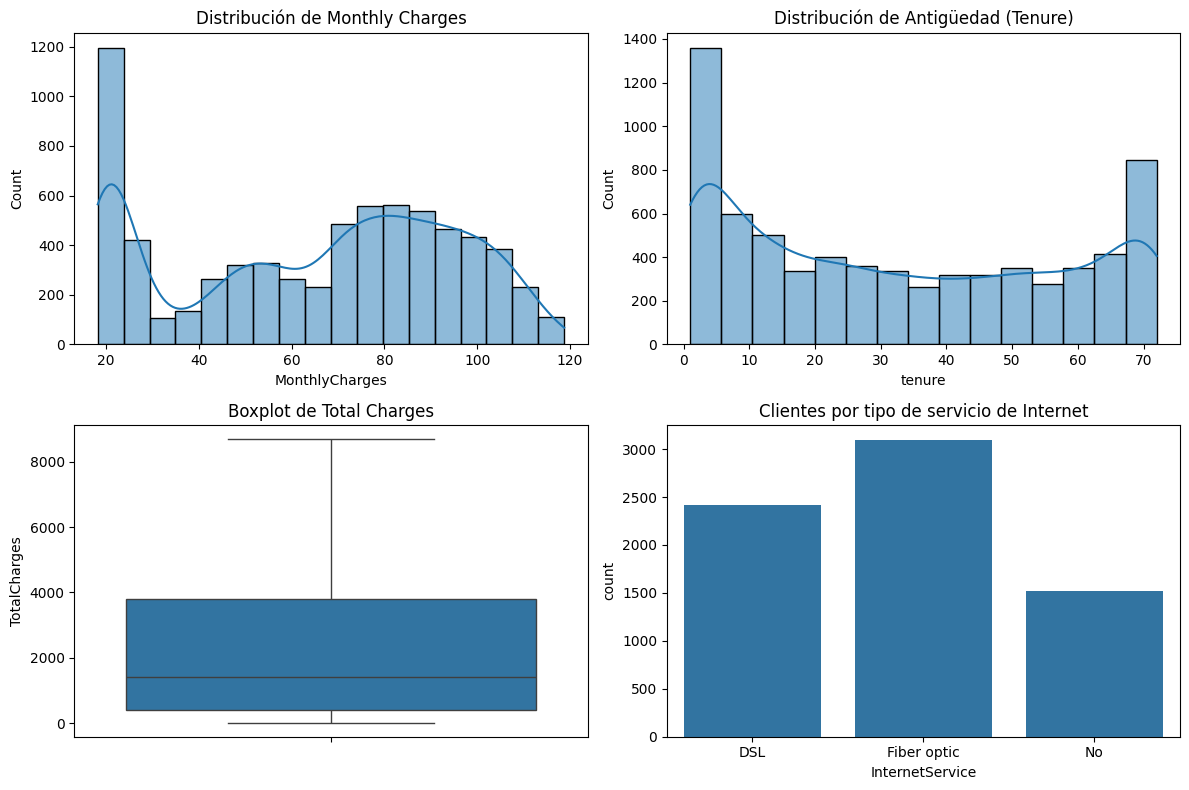

In [10]:
# ANÁLISIS EXPLORATORIO ENFOCADO EN CLUSTERING

plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded.corr(), cmap='coolwarm', center=0)
plt.title("Mapa de correlación entre variables")
plt.show()

# Distribución de algunos campos clave
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df['MonthlyCharges'], kde=True, ax=axs[0, 0])
axs[0, 0].set_title("Distribución de Monthly Charges")

sns.histplot(df['tenure'], kde=True, ax=axs[0, 1])
axs[0, 1].set_title("Distribución de Antigüedad (Tenure)")

sns.boxplot(data=df, y='TotalCharges', ax=axs[1, 0])
axs[1, 0].set_title("Boxplot de Total Charges")

sns.countplot(data=df, x='InternetService', ax=axs[1, 1])
axs[1, 1].set_title("Clientes por tipo de servicio de Internet")

plt.tight_layout()
plt.show()

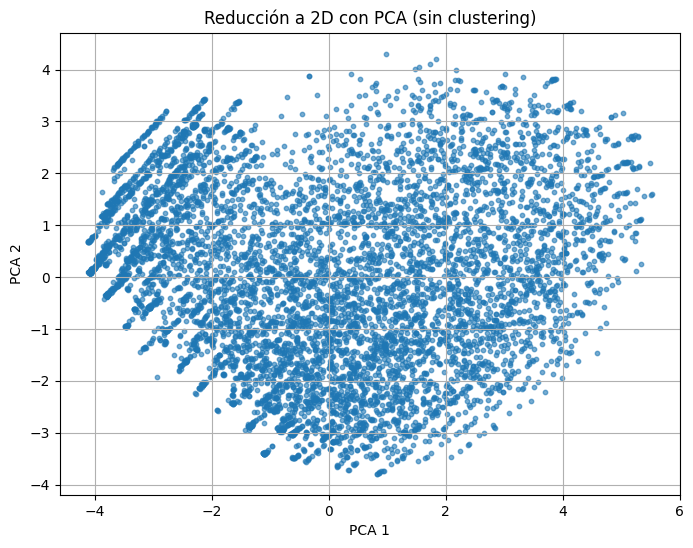

In [4]:
# REDUCCIÓN DE DIMENSIONALIDAD (PCA para visualización)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualización rápida
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.6)
plt.title("Reducción a 2D con PCA (sin clustering)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


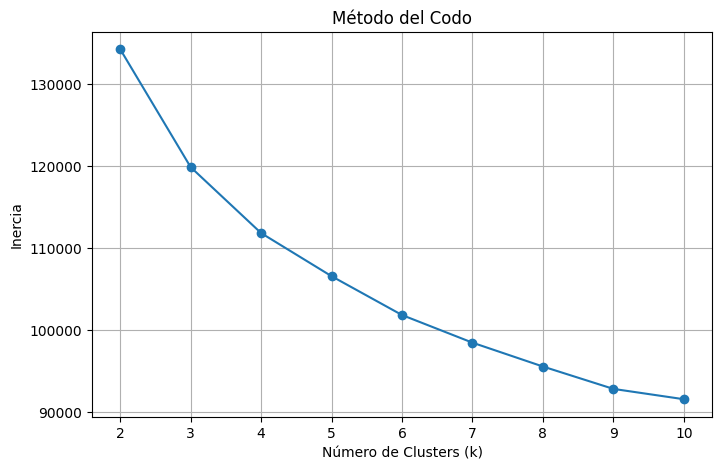

In [5]:

# MÉTODO DEL CODO (para elegir K)
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()


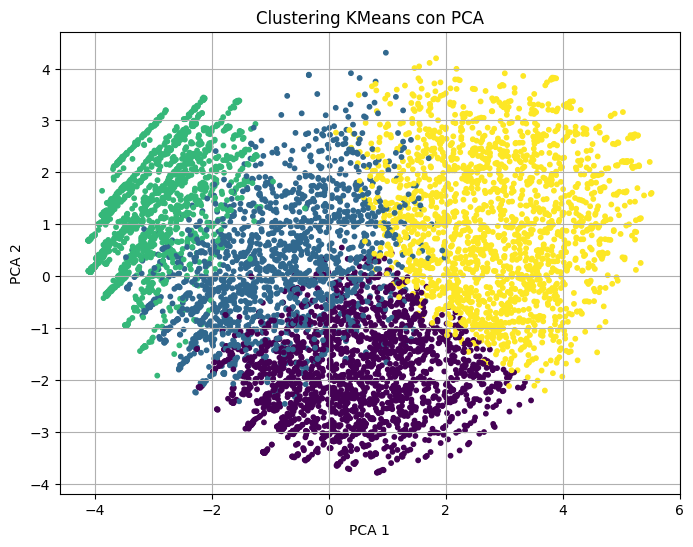

Silhouette Score (KMeans): 0.147


In [6]:
# K-MEANS CLUSTERING
# Elegimos K = 4 (o el valor que se detecte en el codo)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_scaled)

# Visualización en 2D con PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_kmeans, cmap='viridis', s=10)
plt.title("Clustering KMeans con PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

# Silhouette Score
sil_kmeans = silhouette_score(X_scaled, clusters_kmeans)
print(f"Silhouette Score (KMeans): {sil_kmeans:.3f}")


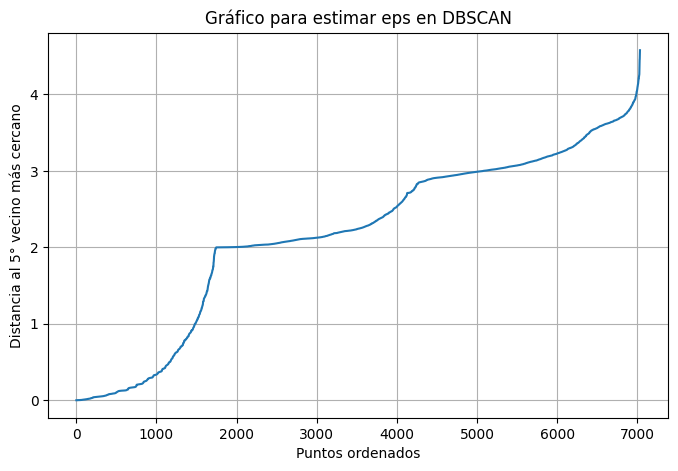

In [7]:
# DBSCAN CLUSTERING
# Usamos Nearest Neighbors para estimar eps
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, 4])  # 4 = n_neighbors - 1
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title("Gráfico para estimar eps en DBSCAN")
plt.xlabel("Puntos ordenados")
plt.ylabel("Distancia al 5° vecino más cercano")
plt.grid(True)
plt.show()


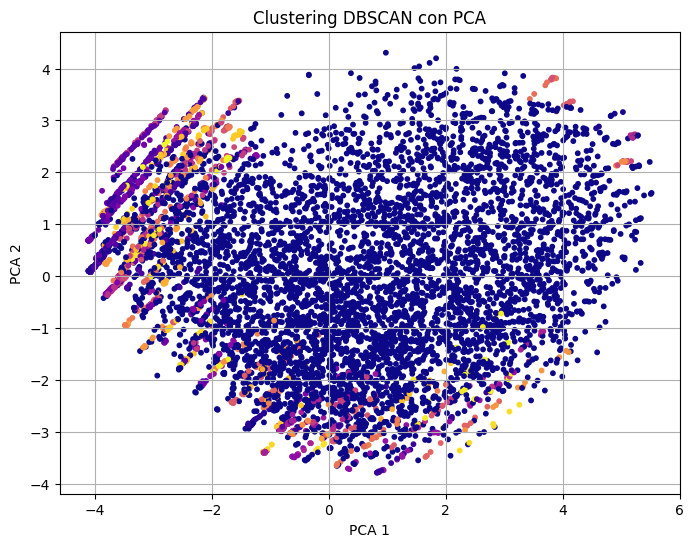

Silhouette Score (DBSCAN): 0.718


In [8]:
# DBSCAN (ajustar eps si es necesario)
dbscan = DBSCAN(eps=2, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_scaled)

# Visualizar con PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_dbscan, cmap='plasma', s=10)
plt.title("Clustering DBSCAN con PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

# Evaluar si hay más de un cluster (excluyendo outliers -1)
if len(set(clusters_dbscan)) > 1 and -1 in clusters_dbscan:
    score = silhouette_score(X_scaled[clusters_dbscan != -1], clusters_dbscan[clusters_dbscan != -1])
    print(f"Silhouette Score (DBSCAN): {score:.3f}")
else:
    print("DBSCAN no identificó suficientes clusters para calcular Silhouette.")


In [9]:
# CLASIFICACIÓN SUPERVISADA CON RED NEURONAL

# Volvemos a cargar la variable objetivo (Churn) que habíamos eliminado
df_supervised = df.copy()
df_supervised['Churn'] = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')['Churn']

# Convertimos la variable objetivo en binaria: 1 si se dio de baja, 0 si no
df_supervised['Churn'] = df_supervised['Churn'].map({'Yes': 1, 'No': 0})

# Separar variables predictoras (X) y variable objetivo (y)
X = df_encoded
y = df_supervised['Churn']

# Dividimos los datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Importamos librerías de Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Creamos el modelo de red neuronal secuencial
model = Sequential()

# Capa de entrada + primera capa oculta con 16 neuronas y activación ReLU
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))

# Segunda capa oculta con 8 neuronas y activación ReLU
model.add(Dense(8, activation='relu'))

# Capa de salida con 1 neurona y activación sigmoidea (para probabilidad binaria)
model.add(Dense(1, activation='sigmoid'))

# Compilamos el modelo: función de pérdida binaria y optimizador Adam
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Entrenamos el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluamos el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Pérdida: {loss:.4f} - Precisión: {accuracy:.4f}')

# Generamos predicciones y mostramos métricas
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))


Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4157 - loss: 0.8228 - val_accuracy: 0.7655 - val_loss: 0.5340
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7663 - loss: 0.5090 - val_accuracy: 0.7804 - val_loss: 0.4621
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7912 - loss: 0.4551 - val_accuracy: 0.7846 - val_loss: 0.4503
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8019 - loss: 0.4267 - val_accuracy: 0.7868 - val_loss: 0.4468
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8036 - loss: 0.4144 - val_accuracy: 0.7790 - val_loss: 0.4457
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8009 - loss: 0.4223 - val_accuracy: 0.7775 - val_loss: 0.4452
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7933 - loss: 0.4223 - val_accuracy: 0.7818 - val_loss: 0.4427
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8059 - loss: 0.4086 - val_accuracy: 0.

# Conclusiones del Análisis de Clustering

# Interpretación de Clusters

**Cluster 0 – Conectividad alta, engagement bajo**  
- **Características:** Cargos mensuales altos y gasto total medio-alto. Baja antigüedad. Alta adopción de fibra óptica y líneas múltiples. Poca utilización de soporte técnico o servicios de streaming.  
- **Perfil:** Clientes con alta conectividad pero bajo uso de servicios adicionales.  
- **Sugerencia:** Incentivar permanencia mediante programas de fidelización o paquetes con servicios complementarios.

**Cluster 1 – Clientes básicos en transición**  
- **Características:** Gastos mensuales y totales moderados. Permanencia intermedia. Baja adopción de fibra óptica y servicios extra.  
- **Perfil:** Clientes de bajo costo, poco dependientes de tecnología.  
- **Sugerencia:** Promover traspaso a servicios digitales con meejores prestaciones.

**Cluster 2 – Fieles pero poco rentables**  
- **Características:** Gastos bajos, pero alta antigüedad. Poco uso de internet, soporte o servicios complementarios.
- **Perfil:** Clientes conservadores, estables pero con baja rentabilidad.
- **Sugerencia:** Mantener como base económica estable. Ofrecer mejoras simples o promociones selectivas según conveniencia.

**Cluster 3 – Clientes premium**  
- **Características:** Altos cargos mensuales y totales, con mucha antigüedad. Alta adopción de todos los servicios.  
- **Perfil:** Usuarios rentables y muy conectados.  
- **Sugerencia:** Retención activa. Ofrecer beneficios preferenciales o planes exclusivos.

# Impacto Estratégico en el Negocio

El análisis no supervisado permitió identificar perfiles claros de clientes a partir de sus características reales, sin necesidad de etiquetas. Esto aporta valor en varios niveles:

- Marketing personalizado: posibilita campañas y mensajes específicos para cada tipo de cliente, mejorando la conversión.
- Retención inteligente: permite aplicar estrategias de retención o fidelización enfocadas según el tipo de cliente.
- Diseño de productos y planes a medida: permite construir ofertas adaptadas a los hábitos reales de uso.
- Reducción de churn: ayuda a anticipar comportamientos de abandono al reconocer patrones similares en otros grupos.
- Visualización y toma de decisiones: la reducción de dimensionalidad con PCA facilita la comunicación de resultados a áreas no técnicas.

En resumen, esta segmentación sirve como base para optimizar ingresos, reducir pérdidas y mejorar la experiencia del cliente, contribuyendo directamente a la sostenibilidad del negocio.

# Reflexión final y análisis de resultados

Para complementar el trabajo principal sobre clustering, decidí incluir un modelo de red neuronal, ya que fue uno de los temas opcionales vistos en clase y me pareció interesante aplicarlo en un caso real.

Implementé una red neuronal multicapa (perceptrón multicapa), entrenada con el mismo dataset de clientes utilizado en el análisis no supervisado, pero esta vez con un enfoque supervisado, prediciendo la probabilidad de que un cliente se dé de baja (churn).

El modelo alcanzó una precisión general del 78%, mostrando un buen desempeño para clasificar clientes que no abandonan el servicio. Sin embargo, para los clientes que sí abandonan, el modelo tuvo un rendimiento más limitado, identificando correctamente alrededor del 50%. Esto refleja un desafío común en problemas con clases desbalanceadas, donde la clase minoritaria (churners) es más difícil de predecir.

Pese a esta limitación, la red neuronal funciona como un sistema de alerta útil que, basado en datos históricos, ayuda a detectar clientes con mayor probabilidad de abandono. Esto tiene un valor muy importante para el negocio, ya que permite:

- Detectar clientes en riesgo antes de que se vayan.  
- Enfocar campañas de retención de forma personalizada.  
- Ahorrar recursos en marketing generalizado.  
- Automatizar decisiones que serían imposibles de tomar manualmente revisando caso por caso.

En resumen, esta red neuronal aporta una herramienta predictiva concreta que complementa muy bien al análisis no supervisado. Mientras el clustering permitió segmentar a los clientes en grupos según su comportamiento, la red neuronal proporcionó una probabilidad concreta de abandono para cada cliente.